In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 6)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import glob

from maelstrom.maelstrom import kepler

/home/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
kicid = 8311110  # SB1
kicid = 6862920  # PB2/SB2 high e
kicid = 10080943  #PB2/SB2 low e
#kicid = 4471379 # SB0

times, dmag = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T

# Subtract midpoint
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid

# mmags
dmmags = dmag * 1000. 

nu_arr = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)[::6]

In [4]:
class RadialVelocity(object):
    def __init__(self, time, velocity, err=None, meta={}):
        self.time = time
        self.vel = velocity
        if err is not None:    # this if looks unintuitive but python doesn't like 'if not err'
            self.err = err
        self.meta = meta

        T=tf.float64
        self.time_tensor = tf.placeholder(T)
        self.rv_tensor = tf.placeholder(T)
        self.err_tensor = tf.placeholder(T)

In [5]:
rvs = []
# Make sure glob is sorted to read in alphabetically
# Glob also has to be * and not ?, otherwise it won't pick up kicid_JDrv data (i.e. single RV)
for file in sorted(glob.glob(f"data/kic{kicid}*_JDrv.txt")):
    rv = RadialVelocity(*np.loadtxt(file, delimiter=",", usecols=(0,1,2)).T, file[15:-9])
    rv.time -= time_mid
    rvs.append(rv)

In [6]:
orbits = pd.read_csv("data/orbits.csv").rename(columns = lambda x: x.strip())
orbits.columns
#orb_params = orbits[orbits.Name == "kic{0}".format(kicid)].iloc[0]
porb = 15.3364
a1 = 43.0
tp = 55782.3
e = 0.449
varpi = 6.016
a1d = a1/86400.0
e_param = np.log(e) - np.log(1.0 - e)

for rv in rvs:
    rv.varpi = 5000
    if rv.meta == 'a':
        rv.ad = a1/86400.0
    else:
        rv.ad = -a1/86400

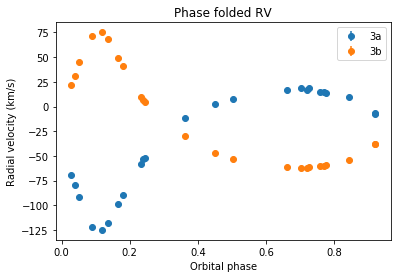

In [7]:
for rv in rvs:
    plt.errorbar(rv.time % porb / porb, rv.vel, rv.err, fmt="o", label=rv.meta)
plt.xlabel('Orbital phase')
plt.ylabel('Radial velocity (km/s)')
plt.title('Phase folded RV')
plt.legend()
plt.show()

In [8]:
sess = tf.InteractiveSession()

The way that TensorFlow works is that you define the operations on `Variable` and `placeholder` objects. Here we describe the model: 

In [9]:
T = tf.float64

# First the variables that we might want to optimize:
porb_tensor = tf.Variable(porb, dtype=T)
tp_tensor = tf.Variable(tp, dtype=T)
tp_tensor = tf.Variable(0.5, dtype=T)
nu_tensor = tf.Variable(nu_arr, dtype=T)
e_param_tensor = tf.Variable(e_param, dtype=T)  # This forces the ecc to be between 0 and 1
e_tensor = 1.0 / (1.0 + tf.exp(-e_param_tensor))
varpi_tensor = tf.Variable(varpi, dtype=T)
log_sigma2_tensor = tf.Variable(0.0, dtype=T)  # Variance from observational uncertainties and model misspecification
gammav_tensor = tf.Variable(np.mean(rvs[0].vel) / 299792.458, dtype=T)

# Array of ad's of length frequency count
ad_tensor = tf.Variable(a1d + np.zeros_like(nu_arr), dtype=T)

for rv in rvs:
    rv.varpi_tensor = tf.Variable(rv.varpi, dtype=T)
    rv.log_rv_sigma2_tensor = tf.Variable(np.log(np.median(rv.err)), dtype=T)  # RV jitter

# These are some placeholders for the data:
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

# Solve Kepler's equation
mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor
ecc_anom = kepler(mean_anom, e_tensor)
true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(times_tensor))

We use a unit vector to describe the time delay in the tau_tensor, and multiply this by an amplitude scalar which is the semi-major axis, ad_tensor.

In [10]:
# Here we define how the time delay will be calculated:
tau_tensor = -(1.0 - tf.square(e_tensor)) * tf.sin(true_anom + varpi_tensor) / (1.0 + e_tensor*tf.cos(true_anom))

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor[:, None] - ad_tensor[None, :] * tau_tensor[:, None])
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor
"""
for rv in rvs:
    # Solve Kepler's equation for the RVs
    rv.mean_anom = (2.0 * np.pi * (rv.time_tensor - tp_tensor) / porb_tensor)
    rv.ecc_anom = kepler(rv.mean_anom, e_tensor)
    rv.true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*rv.ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(rv.time_tensor))

    # Here we define how the RV will be calculated:
    rv.vrad_tensor = 299792.458*(gammav_tensor - 2.0 * np.pi * (ad_tensor / porb_tensor) * (1/tf.sqrt(1.0 - tf.square(e_tensor))) * (tf.cos(rv.true_anom + varpi_tensor) + e_tensor*tf.cos(varpi_tensor)))

    sig2 = tf.square(rv.err_tensor) + tf.exp(rv.log_rv_sigma2_tensor)
    chi = tf.square(rv.rv_tensor - rv.vrad_tensor) / sig2 + tf.log(sig2)
    chi2_tensor += tf.reduce_sum(chi)
"""

"\nfor rv in rvs:\n    # Solve Kepler's equation for the RVs\n    rv.mean_anom = (2.0 * np.pi * (rv.time_tensor - tp_tensor) / porb_tensor)\n    rv.ecc_anom = kepler(rv.mean_anom, e_tensor)\n    rv.true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*rv.ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(rv.time_tensor))\n\n    # Here we define how the RV will be calculated:\n    rv.vrad_tensor = 299792.458*(gammav_tensor - 2.0 * np.pi * (ad_tensor / porb_tensor) * (1/tf.sqrt(1.0 - tf.square(e_tensor))) * (tf.cos(rv.true_anom + varpi_tensor) + e_tensor*tf.cos(varpi_tensor)))\n\n    sig2 = tf.square(rv.err_tensor) + tf.exp(rv.log_rv_sigma2_tensor)\n    chi = tf.square(rv.rv_tensor - rv.vrad_tensor) / sig2 + tf.log(sig2)\n    chi2_tensor += tf.reduce_sum(chi)\n"

Here's how you could evaluate different parts of the model:

In [11]:
# We need to initialize the variables:
tf.global_variables_initializer().run()

data = {times_tensor: times, 
        dmmags_tensor: dmmags}

In [12]:
old_chi2 = sess.run(chi2_tensor, feed_dict=data)

Now we'll fit the parameters. We'll iterate with different subsets a few times.

In [13]:
old_chi2 = sess.run(chi2_tensor, feed_dict=data)
for i in range(2):
    params = [log_sigma2_tensor, tp_tensor]
    #params = [log_sigma2_tensor, porb_tensor, tp_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    params.append(ad_tensor)
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)

    params += [varpi_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
        
    new_chi2 = sess.run(chi2_tensor, feed_dict=data)
    print(old_chi2 - new_chi2)
    if np.abs(old_chi2 - new_chi2) < 1.0:
        break
    old_chi2 = new_chi2

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 240712.140803
  Number of iterations: 10
  Number of functions evaluations: 13
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 240701.976338
  Number of iterations: 11
  Number of functions evaluations: 15
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 240701.976182
  Number of iterations: 1
  Number of functions evaluations: 4
1149335.466167926
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 240698.479741
  Number of iterations: 14
  Number of functions evaluations: 17
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective func

Let's make the updated final plots.

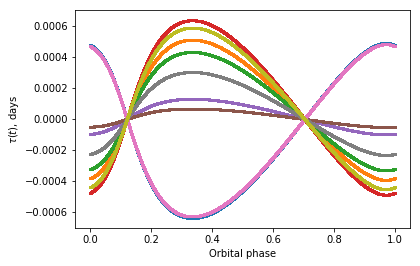

In [14]:
models = tau_tensor[:, None] * ad_tensor[None, :]
plt.plot(times % porb / porb, sess.run(models, feed_dict=data), ".", ms=3)
plt.ylabel(r"$\tau(t)$, days")
plt.xlabel("Orbital phase");

Organise ad tensor values by weighted amount at each frequency of oscillation

In [15]:
ivar = -np.diag(sess.run(tf.hessians(-0.5*chi2_tensor, ad_tensor), feed_dict=data)[0])
ad = sess.run(ad_tensor)
ad *= np.sign(ad[0])
sig = 1.0 / np.sqrt(ivar)
#plt.errorbar(np.arange(len(ad)), ad, yerr=sig, fmt=".")

if np.any(ad < 0):
    m1 = ad > 0
    m2 = ad <= 0
    ad = [
        np.sum(ivar[m1]*ad[m1]) / np.sum(ivar[m1]),
        np.sum(ivar[m2]*ad[m2]) / np.sum(ivar[m2]),
    ]
else:
    ad = [np.sum(ivar*ad) / np.sum(ivar)]

In [17]:
inds = tf.cast(0.5 - 0.5 * (ad_tensor / tf.abs(ad_tensor)), tf.int32)
#ad_params = tf.Variable(ad, dtype=T)
ad_params = tf.Variable(np.multiply(ad,1), dtype=T)
sess.run(ad_params.initializer)
ad_tensor = tf.gather(ad_params, inds)

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor[:, None] - ad_tensor[None, :] * tau_tensor[:, None])
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor

rvs[0].ad_tensor = ad_params[0]
rvs[1].ad_tensor = ad_params[1]

var_dict = {
    porb_tensor: (0, None),
    tp_tensor: (None, None),
    e_param_tensor: (None, None),
    log_sigma2_tensor: (None, None),
    gammav_tensor: (None, None),
    varpi_tensor: (None,None)
}

for rv in rvs:
    # Solve Kepler's equation for the RVs
    rv.mean_anom = (2.0 * np.pi * (rv.time_tensor - tp_tensor) / porb_tensor)
    rv.ecc_anom = kepler(rv.mean_anom, e_tensor)
    rv.true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*rv.ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(rv.time_tensor))

    # Here we define how the RV will be calculated:
    rv.vrad_tensor = -2.0 * np.pi * (rv.ad_tensor / porb_tensor) * (1/tf.sqrt(1.0 - tf.square(e_tensor))) * (tf.cos(rv.true_anom + varpi_tensor) + e_tensor*tf.cos(varpi_tensor))
    rv.vrad_tensor += gammav_tensor
    rv.vrad_tensor *= 299792.458  # c in km/s

    sig2 = tf.square(rv.err_tensor) + tf.exp(rv.log_rv_sigma2_tensor)
    chi = tf.square(rv.rv_tensor - rv.vrad_tensor) / sig2 + tf.log(sig2)
    chi2_tensor += tf.reduce_sum(chi)
    
    var_dict.update({
        rv.log_rv_sigma2_tensor: (None, None)
    })
    
var_dict.update({
    rvs[0].ad_tensor: (None, None),
    rvs[1].ad_tensor: (None, None)
})
    

In [18]:
data = {times_tensor: times, 
        dmmags_tensor: dmmags}

for rv in rvs:
    data.update({
        rv.time_tensor: rv.time,
        rv.rv_tensor: rv.vel,
        rv.err_tensor: rv.err,
    })

In [19]:
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, var_list=list(var_dict.keys()),var_to_bounds=var_dict)
for i in range(5):
    opt.minimize(sess, feed_dict=data)

"""
old_chi2 = sess.run(chi2_tensor, feed_dict=data)
for i in range(5):
    params = [log_sigma2_tensor, tp_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    #params += [rvs[0].ad_tensor, rvs[1].ad_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)

    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    new_chi2 = sess.run(chi2_tensor, feed_dict=data)
    print(old_chi2 - new_chi2)
    if np.abs(old_chi2 - new_chi2) < 1.0:
        break
    old_chi2 = new_chi2
    
"""

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 240779.304712
  Number of iterations: 14
  Number of functions evaluations: 16
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 240779.527168
  Number of iterations: 1
  Number of functions evaluations: 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 240779.527167
  Number of iterations: 1
  Number of functions evaluations: 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 240779.527167
  Number of iterations: 1
  Number of functions evaluations: 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 240779.527

'\nold_chi2 = sess.run(chi2_tensor, feed_dict=data)\nfor i in range(5):\n    params = [log_sigma2_tensor, tp_tensor]\n    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")\n    opt.minimize(sess, feed_dict=data)\n    \n    #params += [rvs[0].ad_tensor, rvs[1].ad_tensor]\n    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")\n    opt.minimize(sess, feed_dict=data)\n\n    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")\n    opt.minimize(sess, feed_dict=data)\n    \n    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")\n    opt.minimize(sess, feed_dict=data)\n    \n    new_chi2 = sess.run(chi2_tensor, feed_dict=data)\n    print(old_chi2 - new_chi2)\n    if np.abs(old_chi2 - new_chi2) < 1.0:\n        break\n    old_chi2 = new_chi2\n    \n'

Text(0.5,1,'Time delay KIC 6862920')

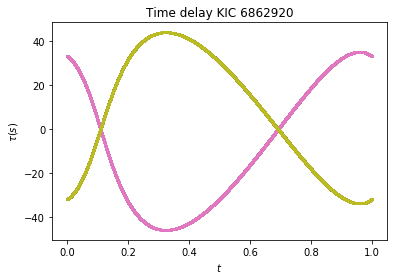

In [20]:
models = tau_tensor[:, None] * ad_tensor[None, :]
plt.plot(times % sess.run(porb_tensor)/sess.run(porb_tensor), 86400.0 * sess.run(models, feed_dict=data), ".", ms=2);
plt.ylabel(r"$\tau(s)$")
plt.xlabel("$t$");
plt.title('Time delay KIC 6862920')

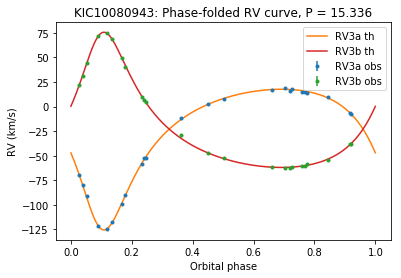

In [21]:
for rv in rvs:
    rv_phi_test = np.sort(np.linspace(0, sess.run(porb_tensor), 5000) % sess.run(porb_tensor))
    vrad = sess.run(rv.vrad_tensor, feed_dict={rv.time_tensor: rv_phi_test})

    plt.errorbar((rv.time % sess.run(porb_tensor))/sess.run(porb_tensor),rv.vel,rv.err,fmt=".",label='RV'+rv.meta+' obs')
    plt.plot(rv_phi_test % sess.run(porb_tensor) /sess.run(porb_tensor), vrad,label='RV' +rv.meta+' th')

plt.xlabel("Orbital phase")
plt.ylabel("RV (km/s)")
plt.title("KIC"+str(kicid) + ": Phase-folded RV curve, P = " + f"{np.round(sess.run(porb_tensor),3)}")
plt.legend()
plt.show()

In [24]:
print(f"e: {np.round(sess.run(e_tensor),3)}")
print(f"porb: {np.round(sess.run(porb_tensor),3)}")
print(f"tp: {np.round(sess.run(tp_tensor),3)}")
print(f"varpi = {np.round(sess.run(varpi_tensor),3)}")
print(f"gamma = {(sess.run(gammav_tensor)*299792.458)} km/s")
for rv in rvs:
    print("asini/c_"+rv.meta+ ": " + str(np.round(sess.run(rv.ad_tensor)*86400.,3)))
print('q:' + str(sess.run(rvs[0].ad_tensor)/sess.run(rvs[1].ad_tensor)))

e: 0.449
porb: 15.336
tp: 55780.099
varpi = 6.016
gamma = -22.951403701718657 km/s
asini/c_3a: 44.968
asini/c_3b: -43.217
q:-1.0405060731825915


q:-1.0405060731825915
